# Load Data and Data split


In [1]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

Since the dataset is too big, we use only 500,000 rows to train and test our model.

We have 62,360,949 rows in our entire data. While building these models let's only have 500,000 rows. (That is .81% of the original data.)

In [2]:
X, _, y, _ = train_test_split(X,y,random_state=1,train_size=.0081,stratify=y)
print(len(X))

505123


In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=1, test_size=0.2, stratify=y)

In [4]:
print(X_dev.shape)
print(X_test.shape)

(404098, 28)
(101025, 28)


After doing the train test split twice, we have aprroximately 50000 rows total, but this dataset is highly imbalanced, we need to do the sampling.

# Hyperparameters Tunning

In [12]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
eval_metric= ['logloss']
label_encoder = [False]
start3 = time.time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}

pipe_XGB_tune = Pipeline([('smote',SMOTE()),('classifier',XGBClassifier(random_state=0))])


pipe_XGB = make_pipeline(GridSearchCV(pipe_XGB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_XGB.fit(X_dev, np.ravel(y_dev))
end3 = time.time()
print("XGBoost model takes " + str(end3-start3) + "seconds")
print("The performance of the XGBoost model on test data is ", pipe_XGB.score(X_test, y_test))
grid_search_XGB = pipe_XGB.named_steps["gridsearchcv"]
print(f"The XGBoost model Best hyperparameters is ", grid_search_XGB.best_params_)

XGBoost model takes 30693.86199760437seconds
The performance of the XGBoost model on test data is  0.7630522088353413
The XGBoost model Best hyperparameters is  {'classifier__learning_rate': 0.15, 'classifier__max_depth': 8, 'classifier__n_estimators': 200}


In [13]:
XGB_prediction = pipe_XGB.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,XGB_prediction)}')
print(f'Recall: {recall_score(y_test,XGB_prediction)}')
print(f'Precision: {precision_score(y_test,XGB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,XGB_prediction)}')

recall, precision = recall_score(y_test,XGB_prediction), precision_score(y_test,XGB_prediction)

Accuracy: 0.998831972284088
Recall: 0.7755102040816326
Precision: 0.7509881422924901
F-1 Score: 0.7630522088353413


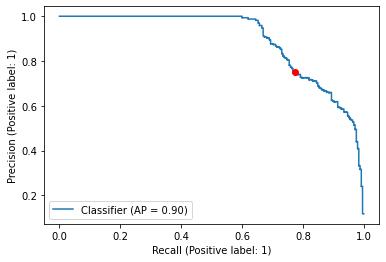

In [14]:
probs = pipe_XGB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

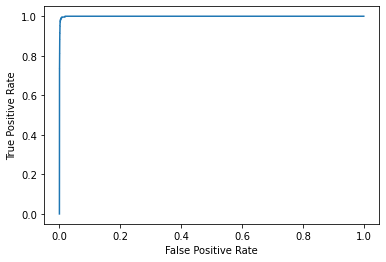

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

# Evaluate on the test set

Since we need to compare our models, we need to keep the random state the same, so we will have the same test dataset. But we uses 1 as random state in previous model, we redo the training process again. But training spends too much time, we will not tunning the model here, and use the best hyperparametrs fron the previous model which are {'classifier__learning_rate': 0.15, 'classifier__max_depth': 8, 'classifier__n_estimators': 200}

In [26]:
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']
X, _, y, _ = train_test_split(X, y, random_state=4995, train_size=.0081,stratify=y)

In [27]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

In [30]:
# Best parameters
learning_rate = [0.15]
n_estimators = [200]
depth = [8]
eval_metric= ['logloss']
label_encoder = [False]
start3 = time.time()

parameter_grid = {'classifier__n_estimators':n_estimators,
                  'classifier__learning_rate':learning_rate,
                  'classifier__max_depth':depth}

pipe_XGB_tunned = make_pipeline(
                          GridSearchCV(Pipeline([('smote',SMOTE()),('classifier',XGBClassifier(random_state=0))]),
                                       param_grid = parameter_grid,
                                       return_train_score=True,cv=StratifiedKFold(n_splits=10,shuffle=False), n_jobs=-1, scoring=['recall','f1'],refit='f1'))
pipe_XGB_tunned.fit(X_dev, np.ravel(y_dev))
end3 = time.time()
print("XGBoost model takes " + str(end3-start3) + "seconds")
print("The performance of the XGBoost model on test data is ", pipe_XGB_tunned.score(X_test, y_test))
grid_search_XGB_tunned = pipe_XGB_tunned.named_steps["gridsearchcv"]

XGBoost model takes 1181.188155889511seconds
The performance of the XGBoost model on test data is  0.7627737226277372


In [32]:
XGB_prediction_tunned = pipe_XGB_tunned.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,XGB_prediction_tunned)}')
print(f'Recall: {recall_score(y_test,XGB_prediction_tunned)}')
print(f'Precision: {precision_score(y_test,XGB_prediction_tunned)}')
print(f'F-1 Score: {f1_score(y_test,XGB_prediction_tunned)}')

recall, precision = recall_score(y_test,XGB_prediction_tunned), precision_score(y_test,XGB_prediction_tunned)

Accuracy: 0.9987131898045039
Recall: 0.8530612244897959
Precision: 0.6897689768976898
F-1 Score: 0.7627737226277372


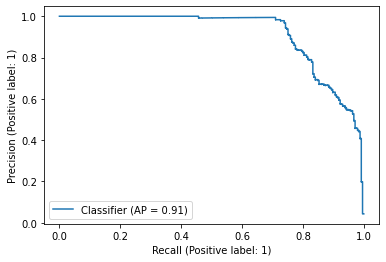

In [39]:
probs = pipe_XGB_tunned.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision);

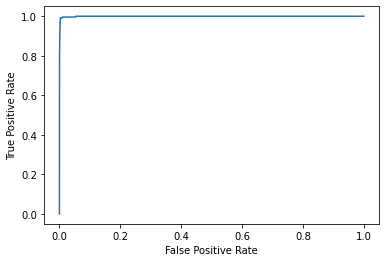

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Then we store this new trained model into a new file

In [41]:
filename = '../processing/XGBoost.sav'
pickle.dump(pipe_XGB_tunned, open(filename, 'wb'))

In [42]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(X_test, y_test)

0.7627737226277372